## Data engineering

Construir un pipeline completo desde la obtención y combinación de datos desde dos fuentes diferentes de datos hasta la exportación final de estos datos a Power BI.

Se ha optado por instalar la librería 'eurostat', con esta podremos obtener datos europeos directamente desde Python, sin necesidad de meternos en la web. 

Los datos con los que se ha decidido trabajar son con el número total de divorcios tanto en España como en el resto de países de Europa. Me ha parecido un dato curioso ya que yo me esperaba una subida del número total de divorcios pero no ha sido así, de hecho ha ido bajando con el paso del tiempo. Para poder entender esta bajada habría que ver también el dato de matrimonios y comparar los porcentajes no los totales, ya que también se han reducido el número de matrimonios. (https://www.elmundo.es/espana/2024/02/02/65bcadfcfc6c83164e8b4579.html)

In [1]:
!pip install eurostat

Estas librerías son las necesarias para poder realizar el trabajo. Pandas permitirá trabajar con los DataFrames, requests permitirá obtener los datos del INE directamente desde la web, eurostat se ha comentado en la celda anterior y json permitirá publicar los datos en PowerBI.

In [2]:
import pandas as pd
import requests
import eurostat
import json

__1. Extract data from table A directly from INE using python__

Lo que se ha hecho es básicamente lo que ya se hizo en clase. He tenido que cambiar el enlace del que obtenía los datos ya que con el anterior los datos que me ofrecía no eran los que yo quería. 

Se realizan una serie de operaciones que permiten obtener el DataFrame que se ve a continuación. 

In [33]:
url = 'https://servicios.ine.es/wstempus/js/ES/DATOS_TABLA/20674?page=1'

r = requests.get(url)
data = r.json()
ine = data[0]
datos = ine['Data']
datos_df = pd.DataFrame(datos)
datos_ine = datos_df[['Valor']].T.rename(columns=datos_df['Anyo']).reset_index()
datos_ine['Country'] = ['ES']
ine_df = datos_ine.iloc[:,::-1].iloc[:,:-2]
ine_df

,Country,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,ES,95427.0,100746.0,96562.0,96824.0,97960.0,95254.0,91645.0,77200.0,86851.0


Tras intentar mergear los dos dataframes y buscar en internet he llegado a la conclusión de que el formato necesario para hacer un merge entre dos dataframes es el siguiente. Para ello ha sido necesario hacer un melt al dataframe anterior.

In [4]:
ine_df_melted = pd.melt(ine_df, id_vars=['Country'], var_name='Periodo', value_name='Valor')
ine_df_melted

,Country,Periodo,Valor
0,ES,2013,95427.0
1,ES,2014,100746.0
2,ES,2015,96562.0
3,ES,2016,96824.0
4,ES,2017,97960.0
5,ES,2018,95254.0
6,ES,2019,91645.0
7,ES,2020,77200.0
8,ES,2021,86851.0


__2. Extract data from table B directly from UE using python__

Para los datos de EU se usa la librería Eurostat ya instalada. En este caso el melt se realiza en la misma celda para tener el mismo formato que el anterior dataframe. 

Se ha decidio eliminar las filas donde se tenían valores nulos por meros temas estéticos, en caso de tener que realizar alguna operación con los datos no se eliminarían directamente sino que habría que decidir qué operación se realiza con ellos.

In [5]:
tabla_eu = eurostat.get_data_df('demo_ndivdur')
datos = tabla_eu.dropna()
data1 = datos[['geo\TIME_PERIOD','2013','2014','2015',
                  '2016','2017', '2018','2019','2020','2021']].reset_index().drop(columns = 'index')
eu_df = data1.rename(columns = {'geo\TIME_PERIOD':'Country'})
eu_df_melted = pd.melt(eu_df, id_vars=['Country'], var_name='Periodo', value_name='Valor')
eu_df_melted

,Country,Periodo,Valor
0,BG,2013,10908.0
1,CZ,2013,27895.0
2,DK,2013,18875.0
3,ES,2013,95427.0
4,FI,2013,13766.0
...,...,...,...
2299,LT,2021,1645.0
2300,MK,2021,552.0
2301,NL,2021,4018.0
2302,SE,2021,4836.0


__3. Join both tables using the common field__

You can use `merge` or `concat`

In [6]:
ine_eu = pd.merge(ine_df_melted,eu_df_melted, how = 'outer')
ine_eu

,Country,Periodo,Valor
0,BG,2013,10908.0
1,BG,2014,10584.0
2,BG,2015,10483.0
3,BG,2016,10603.0
4,BG,2017,10411.0
...,...,...,...
2308,SK,2017,9618.0
2309,SK,2018,9560.0
2310,SK,2019,9466.0
2311,SK,2020,8295.0


__4. Push the resulting df to Power BI service__

Para poder realizar el push ha sido necesario cambiar los datos de un dataframe a un formato json. 

Se muestra una captura de pantalla de la web de Power BI donde se pueden ver las columnas que contenía el dataframe ine_eu, por tanto se puede decir que el push se ha realizado de manera correcta, aunque es algo que ya se podría suponer por el mensaje de '200' del request.

In [34]:
url_pbi = 'https://api.powerbi.com/beta/6afea85d-c323-4270-b69d-a4fb3927c254/datasets/bf0fad79-c64d-4824-bda9-1545379cad37/rows?experience=power-bi&key=kYaZEd7%2F9IAyTppUKNGpDGNiWfl5%2B5hIIZwMZLfBs7Ok6X2tQP%2Fxxd7D5oOn8qQdek6ZQ%2B8aKZ54J86zW1taag%3D%3D'
headers = {'Content-Type': 'application/json'}

ine_eu_json = ine_eu.to_json(orient='records')

response = requests.request(
    method = "POST",
    url = url,
    headers = headers,
    data = json.dumps(ine_eu_json)
    )

response

<Response [200]>

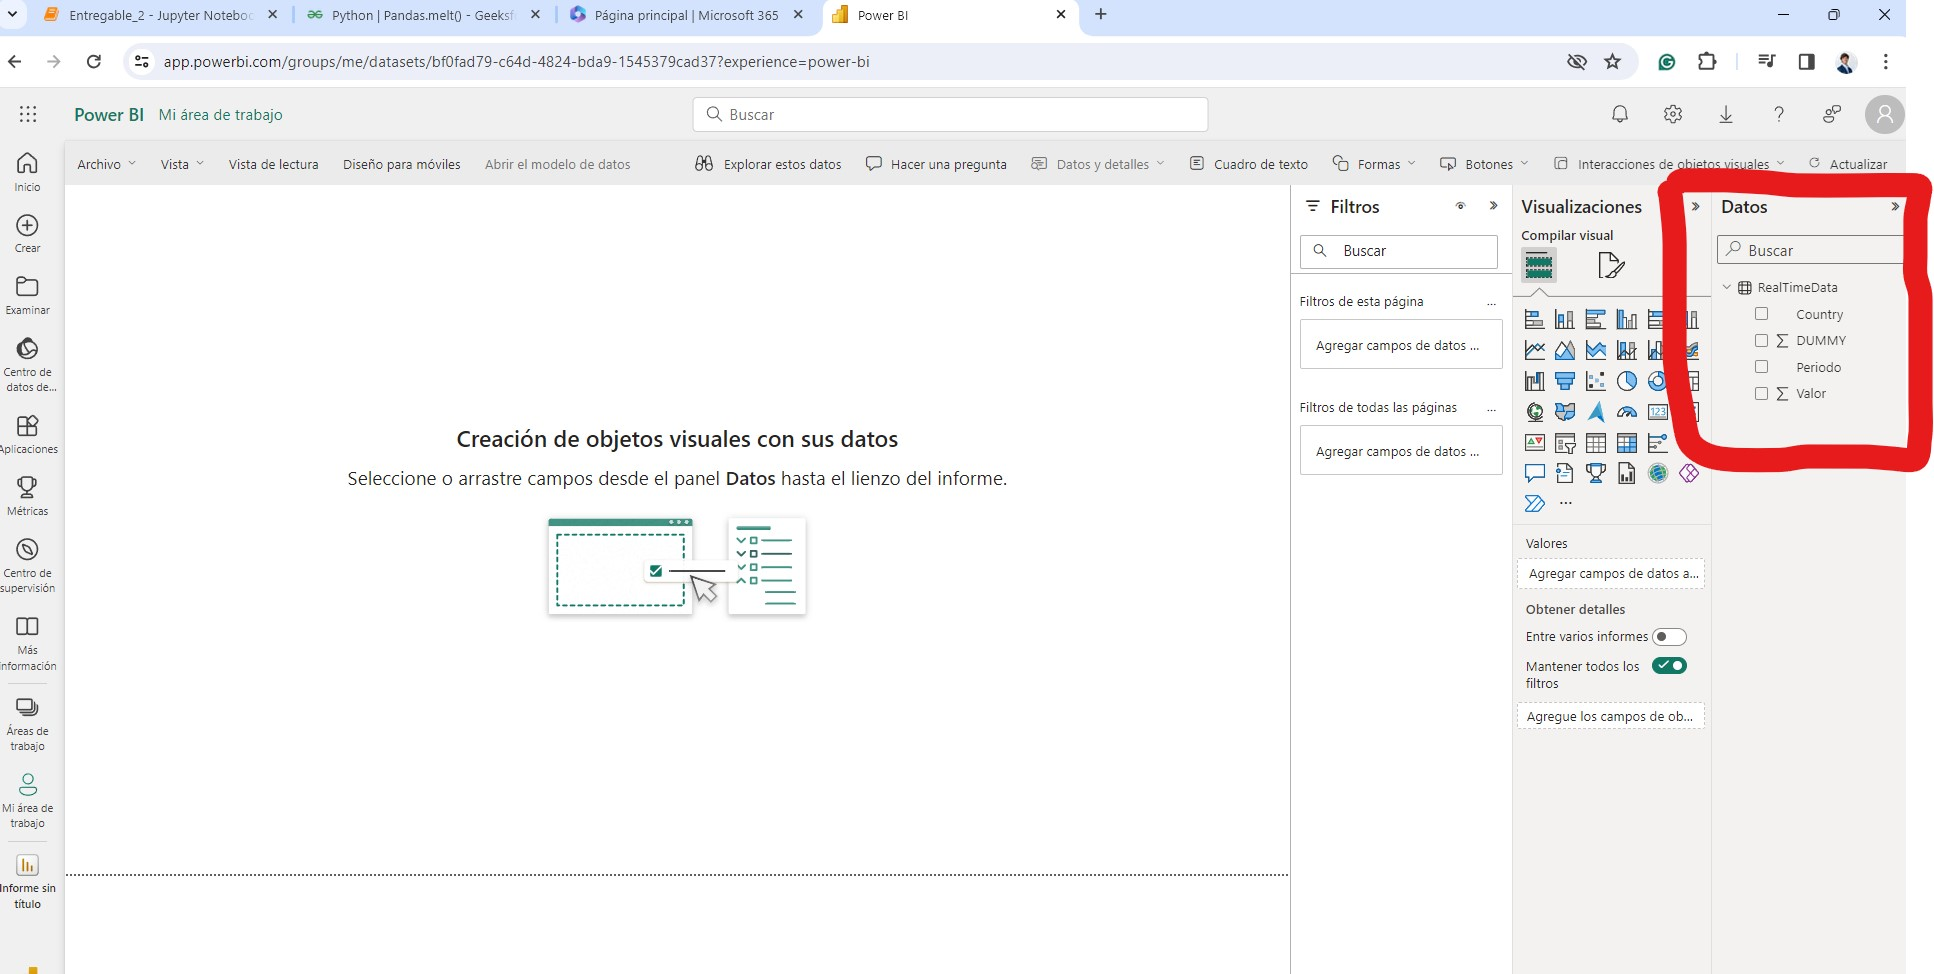

__5. Paste the code you would use to automate the process using your local scheduler__

Para el proceso de automatizar la descarga de datos en local, los archivos necesarios son los que están en la carpeta de scrape. En esta carpeta hay un archivo .py y otro .bat que son los que automatizan el proceso creando el archivo .csv que se puede ver en la imagen inferior.

In [ ]:
file_name = 'C://Users//pablo//Desktop//MASTER//RECOGIDA DE DATOS//ENTREGAS'
time_stamp = datetime.datetime.now().strftime('%Y%m%d_h%Hm%M')
file_name = file_name + time_stamp + '.csv'

ine_eu.to_csv(file_name, sep=',', encoding='utf-8')

Con este código y variando tanto el .bat como el .py conseguimos que se cree un archivo .csv en la carpeta donde lo indicamos como se ve a continuación.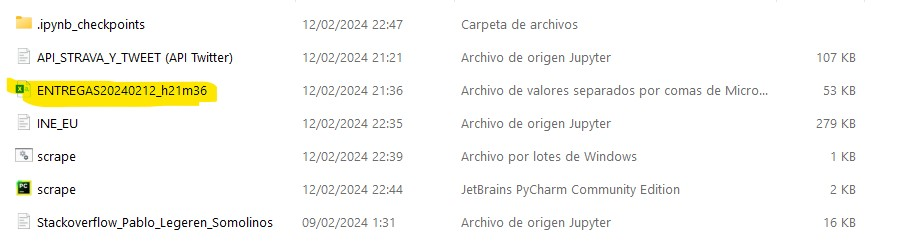